In [9]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
import xml.etree.ElementTree as xet
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [2]:
# Defines constants
dataset_path = "data"
images_path = os.path.join(dataset_path, "images")
labels_path = os.path.join(dataset_path, "labels")
yolo_labels_path = os.path.join(dataset_path, "yolo_labels")

# Ensure YOLO labels directory exists
os.makedirs(yolo_labels_path, exist_ok=True)

In [3]:
# Convert XML labels to YOLO format
def convert_to_yolo(xml_file, output_dir, image_file):
    # Get image dimensions
    with Image.open(image_file) as img:
        width, height = img.size

    # Parse XML label
    tree = ET.parse(xml_file)
    root = tree.getroot()
    yolo_data = []

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        class_id = 0  # Replace with actual class mapping if needed
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        # Normalize coordinates
        x_center = ((xmin + xmax) / 2) / width
        y_center = ((ymin + ymax) / 2) / height
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        yolo_data.append(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}")

    # Save YOLO label
    output_file = os.path.join(output_dir, os.path.basename(xml_file).replace(".xml", ".txt"))
    with open(output_file, "w") as f:
        f.write("\n".join(yolo_data))

# Process all XML files
for xml_file in os.listdir(labels_path):
    if xml_file.endswith(".xml"):
        image_file = os.path.join(images_path, xml_file.replace(".xml", ".png"))
        if os.path.exists(image_file):
            convert_to_yolo(os.path.join(labels_path, xml_file), yolo_labels_path, image_file)

# Split Dataset into YOLO Training and Validation Format
# Paths for split
images_train_path = os.path.join(images_path, "train")
images_val_path = os.path.join(images_path, "val")
labels_train_path = os.path.join(labels_path, "train")
labels_val_path = os.path.join(labels_path, "val")

os.makedirs(images_train_path, exist_ok=True)
os.makedirs(images_val_path, exist_ok=True)
os.makedirs(labels_train_path, exist_ok=True)
os.makedirs(labels_val_path, exist_ok=True)

# List all images and corresponding YOLO label files
images = [f for f in os.listdir(images_path) if f.endswith(".png")]
labels = [f.replace(".png", ".txt") for f in images]

# Split into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Move training data
for img, lbl in zip(train_images, train_labels):
    shutil.copy(os.path.join(images_path, img), os.path.join(images_train_path, img))
    shutil.copy(os.path.join(yolo_labels_path, lbl), os.path.join(labels_train_path, lbl))

# Move validation data
for img, lbl in zip(val_images, val_labels):
    shutil.copy(os.path.join(images_path, img), os.path.join(images_val_path, img))
    shutil.copy(os.path.join(yolo_labels_path, lbl), os.path.join(labels_val_path, lbl))

print("Dataset successfully converted and split!")


Dataset successfully converted and split!


In [4]:
# Double check the YOLO dataset is structured correctly

train_images = os.listdir("data/images/train")
val_images = os.listdir("data/images/val")
train_labels = os.listdir("data/labels/train")
val_labels = os.listdir("data/labels/val")

print(f"Train images: {len(train_images)}, Validation images: {len(val_images)}")
print(f"Train labels: {len(train_labels)}, Validation labels: {len(val_labels)}")


Train images: 346, Validation images: 87
Train labels: 346, Validation labels: 87


In [5]:
# Load the YOLOv8 model (you can use 'yolov8n.pt' for nano or 'yolov8s.pt' for small)
model = YOLO('yolov8n.pt')

# Train the model
model.train(
    data='data/data.yaml',  # Path to the dataset configuration file
    epochs=50,               # Number of training epochs
    imgsz=640,               # Image size (YOLO resizes to this resolution during training)
    batch=16,                # Batch size
    name='license_plate_model'  # Name of the experiment
)


New https://pypi.org/project/ultralytics/8.3.35 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=license_plate_model21, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

train: Scanning /mnt/c/Users/Alexey/Documents/CS 4701/PROJECT/pm475_ERA_ae339_eh538_rw498/data/labels/train... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:01<00:00, 310.41it/s]


train: New cache created: /mnt/c/Users/Alexey/Documents/CS 4701/PROJECT/pm475_ERA_ae339_eh538_rw498/data/labels/train.cache


val: Scanning /mnt/c/Users/Alexey/Documents/CS 4701/PROJECT/pm475_ERA_ae339_eh538_rw498/data/labels/val... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 189.57it/s]


val: New cache created: /mnt/c/Users/Alexey/Documents/CS 4701/PROJECT/pm475_ERA_ae339_eh538_rw498/data/labels/val.cache
Plotting labels to runs/detect/license_plate_model21/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/license_plate_model21
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.24G      1.528      3.104      1.331         18        640: 100%|██████████| 22/22 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


                   all         87         94    0.00326      0.904      0.278      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.16G      1.452      1.962      1.224         16        640: 100%|██████████| 22/22 [00:03<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         87         94      0.743     0.0617      0.391      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.16G       1.45      1.856      1.227         20        640: 100%|██████████| 22/22 [00:03<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


                   all         87         94     0.0902      0.489     0.0922       0.04

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.16G      1.464       1.68      1.293         28        640: 100%|██████████| 22/22 [00:02<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         87         94      0.707      0.574      0.601      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.17G      1.535        1.7      1.271         17        640: 100%|██████████| 22/22 [00:03<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         87         94      0.588      0.585      0.588      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.16G      1.415      1.509      1.247         15        640: 100%|██████████| 22/22 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         87         94      0.761      0.723      0.796      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.16G      1.446      1.376      1.272         22        640: 100%|██████████| 22/22 [00:02<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         87         94      0.721      0.745      0.768      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.18G       1.43      1.339      1.255         23        640: 100%|██████████| 22/22 [00:03<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         87         94      0.704      0.702      0.732      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.16G      1.425      1.258      1.235         26        640: 100%|██████████| 22/22 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

                   all         87         94      0.848      0.819      0.869      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.19G      1.463      1.225      1.265         19        640: 100%|██████████| 22/22 [00:03<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         87         94      0.854      0.734      0.813      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.16G      1.388      1.141      1.212         18        640: 100%|██████████| 22/22 [00:03<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         87         94      0.918      0.798      0.853      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.18G      1.371      1.106      1.211         22        640: 100%|██████████| 22/22 [00:03<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         87         94       0.94      0.798      0.868      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.16G      1.331      1.042       1.22         20        640: 100%|██████████| 22/22 [00:03<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

                   all         87         94      0.942      0.868      0.922      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.16G      1.325      1.047      1.194         23        640: 100%|██████████| 22/22 [00:03<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         87         94      0.913      0.781      0.909      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.17G      1.293      1.031      1.191         15        640: 100%|██████████| 22/22 [00:03<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

                   all         87         94       0.87       0.84       0.87       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.16G      1.309     0.9782      1.185         25        640: 100%|██████████| 22/22 [00:02<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         87         94      0.922      0.883      0.911      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.16G      1.332     0.9678      1.177         22        640: 100%|██████████| 22/22 [00:03<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all         87         94      0.963      0.832      0.905      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.16G      1.269     0.8817      1.159         26        640: 100%|██████████| 22/22 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         87         94      0.916      0.811      0.886      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.16G      1.255     0.8985      1.126         26        640: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

                   all         87         94       0.91       0.86      0.878      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.16G      1.313     0.8969      1.176         32        640: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

                   all         87         94      0.921      0.868      0.879      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.16G      1.293      0.867       1.18         25        640: 100%|██████████| 22/22 [00:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

                   all         87         94      0.941      0.798      0.884      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.17G      1.272     0.9008      1.184         19        640: 100%|██████████| 22/22 [00:03<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         87         94      0.941      0.894      0.901      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.16G      1.239     0.8355      1.144         24        640: 100%|██████████| 22/22 [00:03<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         87         94      0.912      0.851      0.895      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.16G      1.204     0.8155       1.11         24        640: 100%|██████████| 22/22 [00:03<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]

                   all         87         94      0.863       0.84      0.856      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.16G      1.222     0.7745      1.113         21        640: 100%|██████████| 22/22 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         87         94      0.951      0.872      0.921      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.16G      1.224     0.7771      1.132         22        640: 100%|██████████| 22/22 [00:03<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

                   all         87         94      0.953      0.856      0.924      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.16G      1.232     0.7916       1.14         26        640: 100%|██████████| 22/22 [00:03<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         87         94      0.952      0.883       0.91      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.16G      1.182     0.7798      1.095         23        640: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

                   all         87         94      0.926      0.862      0.913      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.16G      1.153     0.7493      1.111         18        640: 100%|██████████| 22/22 [00:03<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]

                   all         87         94      0.924      0.904      0.916      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.16G      1.169     0.7305      1.117         23        640: 100%|██████████| 22/22 [00:03<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         87         94      0.934      0.862      0.897        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.16G      1.148      0.715      1.127         18        640: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all         87         94      0.932      0.871      0.916       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.16G      1.099     0.7151      1.091         18        640: 100%|██████████| 22/22 [00:03<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

                   all         87         94      0.934      0.904      0.934      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.16G      1.135     0.7173      1.103         27        640: 100%|██████████| 22/22 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

                   all         87         94       0.88      0.883      0.913      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.16G      1.109     0.6741      1.094         19        640: 100%|██████████| 22/22 [00:03<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all         87         94      0.942      0.871      0.907      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.16G      1.071     0.7016      1.064         20        640: 100%|██████████| 22/22 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         87         94      0.929      0.872      0.905      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.16G      1.134     0.6868      1.099         23        640: 100%|██████████| 22/22 [00:03<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         87         94      0.917      0.819      0.894      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.16G      1.105     0.6826      1.081         25        640: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         87         94      0.866      0.826      0.869      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.16G      1.034     0.6381      1.065         15        640: 100%|██████████| 22/22 [00:03<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         87         94      0.874      0.894      0.913      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.16G      1.085     0.6292      1.062         28        640: 100%|██████████| 22/22 [00:03<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         87         94       0.85      0.862      0.869      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.17G      1.085      0.647      1.076         15        640: 100%|██████████| 22/22 [00:03<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         87         94      0.881      0.883      0.897       0.53


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.16G      1.091     0.6549      1.079         13        640: 100%|██████████| 22/22 [00:05<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all         87         94      0.912      0.881      0.888      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.16G      1.024     0.6143      1.058         10        640: 100%|██████████| 22/22 [00:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         87         94      0.944      0.904      0.933      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.17G      1.026      0.604      1.038         11        640: 100%|██████████| 22/22 [00:03<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

                   all         87         94      0.939      0.904      0.923      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.16G      1.036     0.5932      1.039         10        640: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

                   all         87         94       0.92      0.894      0.915       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.16G     0.9787     0.5766      1.028         10        640: 100%|██████████| 22/22 [00:03<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]

                   all         87         94       0.92      0.894      0.921      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.16G     0.9631     0.5641      1.017         10        640: 100%|██████████| 22/22 [00:03<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.59it/s]

                   all         87         94       0.92      0.894      0.919      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.16G     0.9566     0.5473      1.015          9        640: 100%|██████████| 22/22 [00:02<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         87         94      0.922      0.894      0.925      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.16G     0.9603     0.5419      1.016         10        640: 100%|██████████| 22/22 [00:03<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]

                   all         87         94      0.921      0.894      0.924      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.17G     0.9308     0.5501      1.008         11        640: 100%|██████████| 22/22 [00:03<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         87         94      0.921      0.894      0.914      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.16G     0.9264     0.5333      1.006         10        640: 100%|██████████| 22/22 [00:03<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         87         94      0.929      0.894      0.918      0.564



50 epochs completed in 0.067 hours.
Optimizer stripped from runs/detect/license_plate_model21/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/license_plate_model21/weights/best.pt, 6.2MB

Validating runs/detect/license_plate_model21/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


                   all         87         94      0.932      0.894      0.925      0.565
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/license_plate_model21


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f5bd71077d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

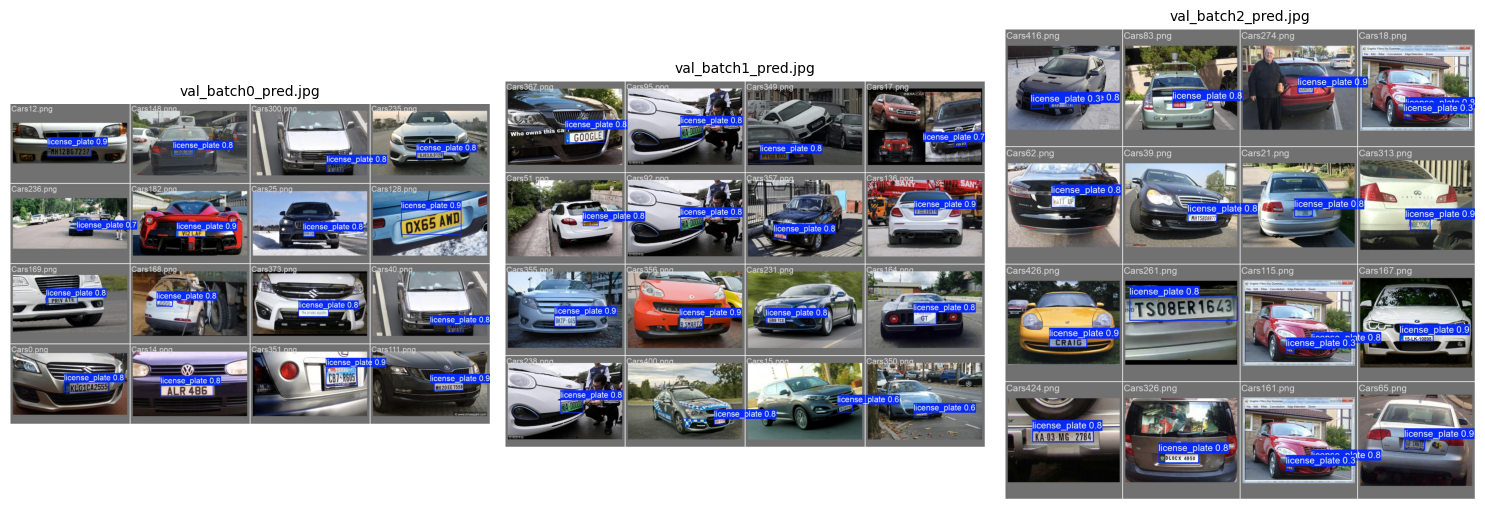

In [19]:
%matplotlib inline

val_results_path = "runs/detect/license_plate_model21"  
image_files = ["val_batch0_pred.jpg", "val_batch1_pred.jpg", "val_batch2_pred.jpg"]

cols = 3  
rows = 1  
fig, axs = plt.subplots(rows, cols, figsize=(15, 5)) 

# Iterate through specified images and add to grid
for ax, image_file in zip(axs.flatten(), image_files):
    image_path = os.path.join(val_results_path, image_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis("off")  
        ax.set_title(image_file, fontsize=10) 
    else:
        ax.axis("off")
        ax.set_title(f"{image_file} not found", fontsize=10, color="red")

plt.tight_layout()
plt.show()
